# Projeto 11: Transfer learning para identificação de objetos  

- Neste projeto, vamos utilizar uma rede neural pré-treinada chamada MobileNet
- Utilizaremos a base de dados TensorFlow Flowers 
- Código baseado na documentação abaixo: 
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras


# Etapa 1: Importação das bibliotecas

In [84]:
#%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
tf.__version__

'2.7.0-dev20210724'

In [85]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

# Etapa 2: Importação do modelo pré-treinado

In [86]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [87]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url, 
                                                        input_shape=(224, 224, 3))])

# Etapa 3: Testes com o modelo pré-treinado

In [88]:
path = "../content/Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("../content/")
zip_object.close()

In [89]:
sample_image= tf.keras.preprocessing.image.load_img(r'../content/Transfer Learning Data/watch.jpg', 
                                                    target_size = (224, 224))

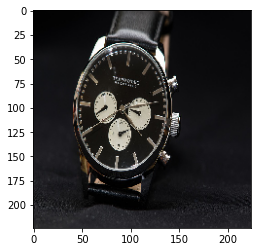

In [90]:
plt.imshow(sample_image);

In [91]:
sample_image = np.array(sample_image) / 255.0

In [92]:
sample_image.shape

(224, 224, 3)

In [93]:
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

In [94]:
predicted_class

array([[ 0.31979933,  0.7227179 , -0.46497566, ...,  0.25369614,
        -1.4674318 , -0.00161375]], dtype=float32)

In [95]:
len(predicted_class[0])

1001

In [96]:
predicted_class.shape

(1, 1001)

In [97]:
predicted_class = np.argmax(predicted_class)
predicted_class

827

In [98]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [99]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [100]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [101]:
len(imagenet_labels)

1001

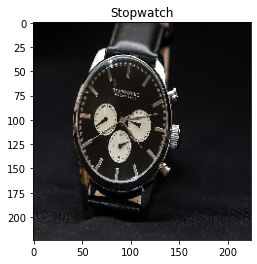

In [102]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

# Etapa 4: Testes com um conjunto de imagens

In [103]:
flowers_data_url = tf.keras.utils.get_file('flower_photos', 
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

In [104]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

Found 3670 images belonging to 5 classes.


In [105]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [106]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

(64, 1001)

In [107]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['daisy', 'picket fence', 'daisy', 'vase', 'daisy', 'daisy',
       'buckeye', 'cardoon', 'balloon', 'hip', 'cardoon', 'daisy',
       'daisy', 'paddlewheel', 'daisy', 'sea urchin', 'daisy',
       'lampshade', 'cardoon', 'birdhouse', 'pot', 'coral fungus',
       'rapeseed', 'bee', 'daisy', 'barn spider', 'daisy', 'bee', 'ant',
       'rapeseed', 'picket fence', 'quill', 'cardoon', 'cockroach',
       'mushroom', 'cardoon', 'hip', 'sulphur butterfly', 'bee',
       'rapeseed', 'bee', 'slug', 'leaf beetle', 'hip', 'picket fence',
       'ear', 'daisy', 'pot', 'rapeseed', 'bonnet', 'picket fence', 'bee',
       'ant', 'pot', 'daisy', 'sea urchin', 'safety pin', 'maze', 'ear',
       'daisy', 'velvet', 'daisy', 'porcupine', 'daisy'], dtype='<U30')

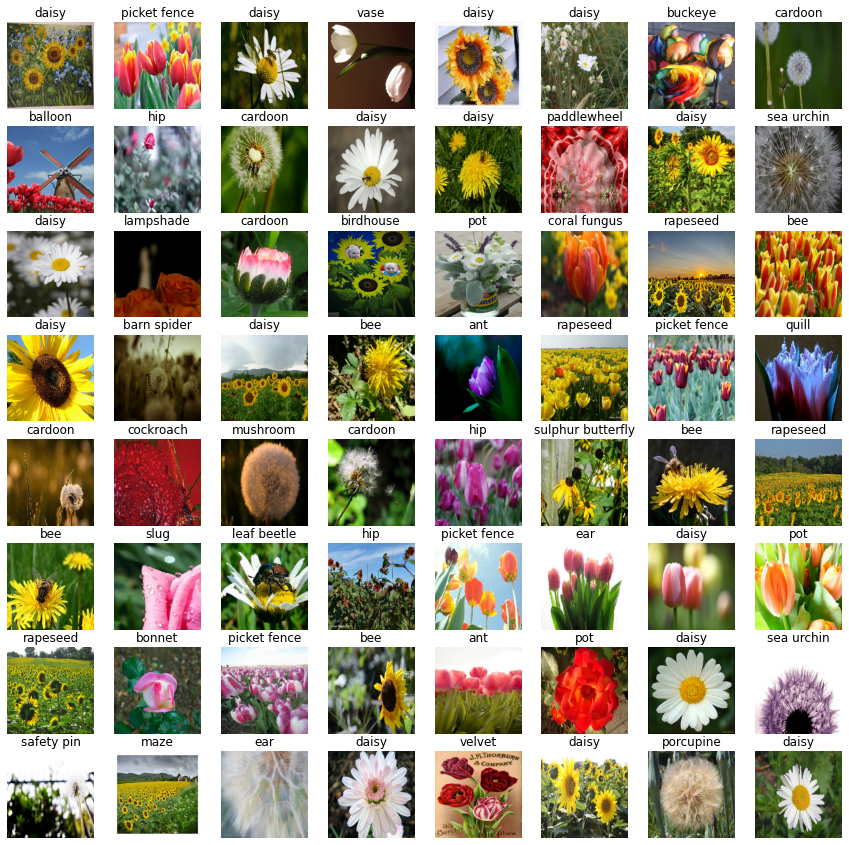

In [109]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Etapa 5: Transfer learning

Download do MobileNet sem o topo do modelo:
https://tfhub.dev/s?module-type=image-feature-vector&q=tf2


In [110]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [111]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))

In [113]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [114]:
MobileNet_feature_extractor_layer.trainable = False

In [115]:
flower_data.num_classes

5

In [116]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])

In [117]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [118]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(flower_data, epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 58 steps
Epoch 1/50
58/58 [==============================] - 13s 232ms/step - loss: 0.8469 - accuracy: 0.6820
Epoch 2/50
58/58 [==============================] - 12s 201ms/step - loss: 0.3991 - accuracy: 0.8651
Epoch 3/50
58/58 [==============================] - 12s 201ms/step - loss: 0.3144 - accuracy: 0.8951
Epoch 4/50
58/58 [==============================] - 12s 200ms/step - loss: 0.2696 - accuracy: 0.9106
Epoch 5/50
58/58 [==============================] - 12s 201ms/step - loss: 0.2328 - accuracy: 0.9278
Epoch 6/50
58/58 [==============================] - 11s 198ms/step - loss: 0.2093 - accuracy: 0.9332
Epoch 7/50
58/58 [==============================] - 12s 210ms/step - loss: 0.1890 - accuracy: 0.9441
Epoch 8/50
58/58 [==============================] - 12s 209ms/step - loss: 0.1720 - accuracy: 0.9504
Epoch 9/50
58/58 [==============================] - 12s 201ms/step - loss: 0.1580 - accuracy: 0.9564
Epoch 10/50
58/58 [==============================] - 12s 203ms/step - lo

# Etapa 6: Avaliação do modelo

In [ ]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [ ]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [ ]:
class_names = np.array([key.title() for key, value in class_names])

In [ ]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [ ]:
predicted_id

array([0, 4, 1, 4, 2, 4, 3, 2, 4, 0, 1, 1, 3, 1, 1, 2, 4, 0, 1, 1, 4, 3,
       2, 2, 1, 4, 0, 2, 1, 4, 0, 3, 4, 0, 3, 0, 0, 1, 3, 4, 3, 4, 3, 3,
       2, 0, 1, 0, 0, 1, 1, 3, 4, 3, 3, 1, 4, 1, 0, 1, 0, 1, 0, 4])

In [ ]:
predicted_label_batch

array(['Daisy', 'Tulips', 'Dandelion', 'Tulips', 'Roses', 'Tulips',
       'Sunflowers', 'Roses', 'Tulips', 'Daisy', 'Dandelion', 'Dandelion',
       'Sunflowers', 'Dandelion', 'Dandelion', 'Roses', 'Tulips', 'Daisy',
       'Dandelion', 'Dandelion', 'Tulips', 'Sunflowers', 'Roses', 'Roses',
       'Dandelion', 'Tulips', 'Daisy', 'Roses', 'Dandelion', 'Tulips',
       'Daisy', 'Sunflowers', 'Tulips', 'Daisy', 'Sunflowers', 'Daisy',
       'Daisy', 'Dandelion', 'Sunflowers', 'Tulips', 'Sunflowers',
       'Tulips', 'Sunflowers', 'Sunflowers', 'Roses', 'Daisy',
       'Dandelion', 'Daisy', 'Daisy', 'Dandelion', 'Dandelion',
       'Sunflowers', 'Tulips', 'Sunflowers', 'Sunflowers', 'Dandelion',
       'Tulips', 'Dandelion', 'Daisy', 'Dandelion', 'Daisy', 'Dandelion',
       'Daisy', 'Tulips'], dtype='<U10')

In [ ]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([0, 4, 1, 4, 2, 4, 3, 2, 4, 0, 1, 1, 3, 1, 1, 2, 4, 0, 1, 1, 4, 3,
       2, 2, 1, 4, 0, 2, 1, 4, 0, 3, 4, 0, 3, 0, 0, 1, 3, 4, 3, 4, 3, 3,
       2, 0, 1, 0, 0, 1, 1, 3, 4, 3, 3, 1, 4, 1, 0, 1, 0, 1, 0, 4])

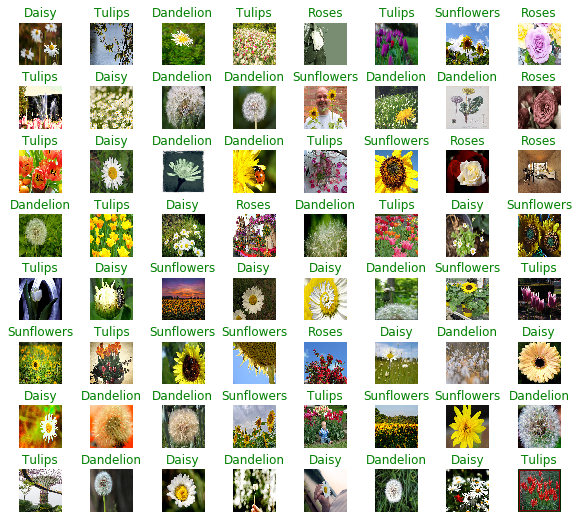

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')